# 1. Introduction

1.1 Ringkasan

Analisis keranjang pasar akan membantu memahami perilaku pembelian pelanggan. Dalam sebuah keranjang belanja, biasanya terdapat beberapa item sebagai kombinasi tergantung pada preferensi pelanggan yang berbeda. Mengetahui barang apa yang akan datang setelah barang tertentu, perencana rak akan memiliki gagasan yang lebih baik tentang barang apa yang harus disatukan. Juga, manajer ritel akan lebih memahami jenis barang apa yang harus disimpan di gudang untuk mencegah kekurangan.

# 2. Process

In [ ]:
import numpy as np 
import pandas as pd 
from itertools import permutations
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import parallel_coordinates
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
import networkx as nx
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
import plotly
from plotly.graph_objs import *

import library

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Groceries data.csv")

In [ ]:
bk = pd.read_csv("/content/drive/MyDrive/basket.csv")
df

Member_number        Date        itemDescription  year  month  day  \
0               1808  2015-07-21         tropical fruit  2015      7   21   
1               2552  2015-05-01             whole milk  2015      5    1   
2               2300  2015-09-19              pip fruit  2015      9   19   
3               1187  2015-12-12       other vegetables  2015     12   12   
4               3037  2015-01-02             whole milk  2015      1    2   
...              ...         ...                    ...   ...    ...  ...   
38760           4471  2014-08-10          sliced cheese  2014      8   10   
38761           2022  2014-02-23                  candy  2014      2   23   
38762           1097  2014-04-16               cake bar  2014      4   16   
38763           1510  2014-03-12  fruit/vegetable juice  2014      3   12   
38764           1521  2014-12-26               cat food  2014     12   26   

       day_of_week  
0                1  
1                4  
2                5  
3                5  
4                4  
...            ...  
38760            6  
38761            6  
38762            2  
38763            2  
38764            4  

[38765 rows x 7 columns]

Import 2 dataset. BK merupakan singkatan dari "backup" atau "bookkeeping", sedangkan DF merupakan singkatan dari "data frame" (dalam pandas).

In [ ]:
print(len(df['Member_number'].unique()))
print(len(df['itemDescription'].unique()))

3898
167


menghitung jumlah nilai unik dalam kolom Member_number dan itemDescription dari dataframe df

In [ ]:
freq_items = df['itemDescription'].value_counts()
freq_items.head(10)

whole milk          2502
other vegetables    1898
rolls/buns          1716
soda                1514
yogurt              1334
root vegetables     1071
tropical fruit      1032
bottled water        933
sausage              924
citrus fruit         812
Name: itemDescription, dtype: int64

mengetahui item yang paling sering terjual dalam dataframe df

In [ ]:
fig = px.bar(data_frame=freq_items.head(40), title='Top 40 Items', color=freq_items.head(40),
                 labels={
                     "index": "Items",
                     "values": "Quantity",
                     'lift': 'Lift'
                 })
fig.update_layout(title_x=0.5, title_y=0.86)
fig.show()

Baris kode di atas memperlihatkan sebuah plot batang (bar chart) menggunakan modul plotly express (px). Plot ini dibuat dari sebuah dataframe yang disimpan dalam variabel `freq_items` dan hanya menampilkan 40 baris pertama dari data tersebut dengan menggunakan method `.head(40)`. Judul plot diatur dengan menggunakan parameter title, sementara label sumbu x dan y diatur dengan menggunakan parameter labels.

Method `update_layout()` digunakan untuk memperbarui layout dari plot, seperti mengatur posisi judul plot dengan menggunakan parameter `title_x` dan `title_y`. Terakhir, `method show()` digunakan untuk menampilkan plot tersebut.

Tujuan dari plot batang ini adalah untuk menampilkan jumlah kemunculan setiap item dalam dataframe freq_items dalam bentuk visual yang mudah dipahami. Dengan menggunakan plot ini, kita dapat dengan mudah membandingkan jumlah kemunculan item yang berbeda dan mengetahui item mana yang paling sering terjual.

In [ ]:
user_id = df['Member_number'].unique()
items = [list(df.loc[df['Member_number'] == id, 'itemDescription']) for id in user_id]
print(items[0])

['tropical fruit', 'long life bakery product', 'meat', 'sugar', 'rolls/buns', 'semi-finished bread', 'whole milk', 'citrus fruit', 'candy', 'napkins']


Baris kode di atas digunakan untuk mengambil semua nilai unik dari kolom `Member_number` dari dataframe df dan menyimpannya dalam variabel user_id. Kemudian, list comprehension digunakan untuk membuat sebuah list yang berisi daftar item yang dibeli oleh setiap pelanggan (disebutkan dengan ID pelanggan di variabel user_id). Setiap daftar item tersebut dihasilkan dengan menggunakan perintah `df.loc[df['Member_number'] == id, 'itemDescription'],` yang akan mengembalikan seluruh item yang dibeli oleh pelanggan dengan ID yang sesuai.

Akhirnya, perintah `print(items[0])` digunakan untuk menampilkan daftar item yang dibeli oleh pelanggan dengan ID pertama (indeks 0) dari list items.

Tujuan dari baris kode tersebut adalah untuk mengetahui item apa saja yang dibeli oleh setiap pelanggan di dataframe df, yang mungkin berguna untuk mengetahui tren pembelian pelanggan atau mengambil keputusan bisnis

In [ ]:
TE = TransactionEncoder()
TE.fit(items)
item_transformed = TE.transform(items)
item_matrix = pd.DataFrame(item_transformed, columns = TE.columns_)
item_matrix.head()

Instant food products  UHT-milk  abrasive cleaner  artif. sweetener  \
0                  False     False             False             False   
1                  False     False             False             False   
2                  False     False             False             False   
3                  False     False             False             False   
4                  False     False             False             False   

   baby cosmetics   bags  baking powder  bathroom cleaner   beef  berries  \
0           False  False          False             False  False    False   
1           False  False          False             False  False    False   
2           False  False          False             False  False    False   
3           False  False          False             False  False    False   
4           False  False          False             False  False    False   

   ...  turkey  vinegar  waffles  whipped/sour cream  whisky  white bread  \
0  ...   False    False    False               False   False        False   
1  ...   False    False    False               False   False        False   
2  ...   False    False    False               False   False        False   
3  ...   False    False    False               False   False        False   
4  ...   False    False    False               False   False         True   

   white wine  whole milk  yogurt  zwieback  
0       False        True   False     False  
1       False        True   False     False  
2        True       False   False     False  
3       False       False   False     False  
4       False        True   False     False  

[5 rows x 167 columns]

Baris kode di atas menggunakan kelas TransactionEncoder dari modul `mlxtend.preprocessing` untuk mengkonversi sebuah list transaksi (daftar item yang dibeli oleh pelanggan) menjadi sebuah matrix 0-1. Proses ini disebut sebagai "one-hot encoding" dari list transaksi tersebut.

Untuk mengkonversi list transaksi menjadi matrix 0-1, pertama-tama kelas TransactionEncoder diinisialisasi dan method `fit()` digunakan untuk mempelajari list transaksi. Kemudian, method `transform()` digunakan untuk mengkonversi list transaksi menjadi matrix 0-1. Hasil dari proses tersebut disimpan dalam variabel `item_transformed`.

Kemudian, sebuah dataframe panda diinisialisasi dengan menggunakan matrix 0-1 yang telah dikonversi tadi, dan nama kolom diatur dengan menggunakan atribut `columns_` dari objek TransactionEncoder. Akhirnya, beberapa baris pertama dari dataframe tersebut ditampilkan dengan menggunakan method `head()`.

Tujuan dari baris kode tersebut adalah untuk mengkonversi list transaksi menjadi matrix 0-1, yang mungkin berguna untuk menganalisis pola pembelian pelanggan dengan menggunakan teknik-teknik analisis asosiasi atau teknik analisis lainnya. Matrix 0-1 yang dihasilkan akan memiliki satu kolom untuk setiap item yang terdapat dalam list transaksi, dan setiap baris akan menunjukkan item apa saja yang dibeli oleh seorang pelanggan. 

In [ ]:
freq_items = apriori(item_matrix, min_support=0.01, use_colnames=True, max_len=2)
freq_items.sort_values(by = "support", ascending = False)

support                             itemsets
113   0.458184                         (whole milk)
69    0.376603                   (other vegetables)
84    0.349666                         (rolls/buns)
94    0.313494                               (soda)
114   0.282966                             (yogurt)
...        ...                                  ...
414   0.010005           (butter milk, frankfurter)
705   0.010005               (dog food, whole milk)
882   0.010005       (newspapers, hygiene articles)
1106  0.010005                      (waffles, pork)
790   0.010005  (hamburger meat, frozen vegetables)

[1242 rows x 2 columns]

Baris kode di atas menggunakan fungsi `apriori()` dari modul `mlxtend.frequent_patterns` untuk menemukan item yang sering muncul bersama-sama dalam list transaksi yang tersimpan dalam dataframe `item_matrix`. Fungsi ini menggunakan algoritma Apriori untuk menemukan itemset yang memenuhi kriteria minimum dukungan (support) yang ditentukan.

Untuk menemukan itemset yang memenuhi kriteria minimum dukungan, pertama-tama fungsi `apriori()` dijalankan dengan parameter `min_support` yang menentukan nilai dukungan minimum yang diperlukan. Kemudian, parameter `use_colnames` diatur sebagai `True` untuk menggunakan nama kolom dataframe sebagai nama item dalam hasil yang dihasilkan. Terakhir, parameter `max_len` diatur sebagai 2 untuk menentukan bahwa hanya itemset dengan panjang maksimal 2 yang akan dikembalikan oleh fungsi `apriori()`.

Hasil dari fungsi `apriori(`) disimpan dalam variabel `freq_items`, kemudian diurutkan berdasarkan nilai dukungan dengan menggunakan method `sort_values()` dan menampilkan hasil terurut tersebut dengan menggunakan perintah `print()`.

Tujuan dari baris kode tersebut adalah untuk menemukan item yang sering muncul bersama-sama dalam list transaksi, yang mungkin berguna untuk mengetahui tren pembelian pelanggan atau mengambil keputusan bisnis lainnya.

In [ ]:
rules = association_rules(freq_items, metric = "confidence", min_threshold = 0)
rules

antecedents      consequents  antecedent support  consequent support  \
0             (beef)       (UHT-milk)            0.119548            0.078502   
1         (UHT-milk)           (beef)            0.078502            0.119548   
2         (UHT-milk)   (bottled beer)            0.078502            0.158799   
3     (bottled beer)       (UHT-milk)            0.158799            0.078502   
4         (UHT-milk)  (bottled water)            0.078502            0.213699   
...              ...              ...                 ...                 ...   
2247    (white wine)     (whole milk)            0.044125            0.458184   
2248        (yogurt)     (white wine)            0.282966            0.044125   
2249    (white wine)         (yogurt)            0.044125            0.282966   
2250        (yogurt)     (whole milk)            0.282966            0.458184   
2251    (whole milk)         (yogurt)            0.458184            0.282966   

       support  confidence      lift  leverage  conviction  
0     0.010518    0.087983  1.120775  0.001133    1.010396  
1     0.010518    0.133987  1.120775  0.001133    1.016672  
2     0.014879    0.189542  1.193597  0.002413    1.037933  
3     0.014879    0.093700  1.193597  0.002413    1.016769  
4     0.021293    0.271242  1.269268  0.004517    1.078960  
...        ...         ...       ...       ...         ...  
2247  0.023602    0.534884  1.167400  0.003384    1.164905  
2248  0.016419    0.058024  1.314976  0.003933    1.014754  
2249  0.016419    0.372093  1.314976  0.003933    1.141944  
2250  0.150590    0.532185  1.161510  0.020940    1.158185  
2251  0.150590    0.328667  1.161510  0.020940    1.068076  

[2252 rows x 9 columns]

Tujuan dari baris kode tersebut adalah untuk menemukan aturan asosiasi dari itemset yang telah ditemukan sebelumnya, yang mungkin berguna untuk mengetahui tren pembelian pelanggan atau mengambil keputusan bisnis lainnya. Dengan mengetahui aturan asosiasi dari itemset yang sering muncul bersama-sama, kita dapat mengambil keputusan seperti menyarankan item B kepada pelanggan yang sedang membeli item A, atau mengelompokkan item A dan item B dalam satu promosi bersama untuk meningkatkan penjualan.

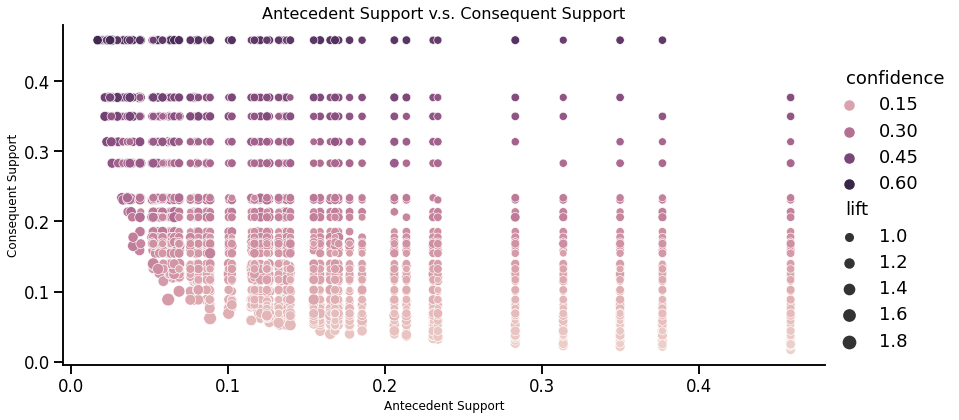

In [ ]:
sns.set_context("talk")
sns.relplot(x='antecedent support', y='consequent support', data=rules, 
            size='lift', hue='confidence', height=6, aspect=2)
plt.title("Antecedent Support v.s. Consequent Support", fontsize=16, y=1.02)
plt.xlabel('Antecedent Support', fontsize=12)
plt.ylabel('Consequent Support', fontsize=12)
plt.show()

Tujuan dari baris kode tersebut adalah untuk memvisualisasikan aturan asosiasi yang telah dihitung sebelumnya dengan menggunakan plot scatter, sehingga kita dapat dengan mudah membandingkan nilai dukungan dari item A dan item B serta melihat hubungan antara nilai lift dan confidence dari setiap aturan asosiasi. Dengan memvisualisasikan data tersebut, kita dapat dengan mudah memahami aturan asosiasi yang paling signifikan dan mengambil keputusan bisnis yang tepat sesuai dengan aturan tersebut. Sebagai contoh, jika kita menemukan bahwa aturan asosiasi yang memiliki nilai lift yang tinggi juga memiliki nilai confidence yang tinggi, maka kita dapat mengasumsikan bahwa aturan tersebut cukup signifikan dan dapat diandalkan untuk mengambil keputusan bisnis.

In [ ]:
def zhangs_rule(rules):
    rule_support = rules['support'].copy()
    rule_ante = rules['antecedent support'].copy()
    rule_conseq = rules['consequent support'].copy()
    num = rule_support - (rule_ante * rule_conseq)
    denom = np.max((rule_support * (1 - rule_ante).values, 
                          rule_ante * (rule_conseq - rule_support).values), axis = 0)
    return num / denom

rules_zhangs_list = zhangs_rule(rules)
rules = rules.assign(zhang = rules_zhangs_list)
rules.head()

antecedents      consequents  antecedent support  consequent support  \
0          (beef)       (UHT-milk)            0.119548            0.078502   
1      (UHT-milk)           (beef)            0.078502            0.119548   
2      (UHT-milk)   (bottled beer)            0.078502            0.158799   
3  (bottled beer)       (UHT-milk)            0.158799            0.078502   
4      (UHT-milk)  (bottled water)            0.078502            0.213699   

    support  confidence      lift  leverage  conviction     zhang  
0  0.010518    0.087983  1.120775  0.001133    1.010396  0.122392  
1  0.010518    0.133987  1.120775  0.001133    1.016672  0.116940  
2  0.014879    0.189542  1.193597  0.002413    1.037933  0.176014  
3  0.014879    0.093700  1.193597  0.002413    1.016769  0.192815  
4  0.021293    0.271242  1.269268  0.004517    1.078960  0.230217

Baris kode di atas menggunakan fungsi `zhangs_rule()` untuk menghitung nilai indeks Zhang dari setiap aturan asosiasi yang disimpan dalam dataframe rules. Indeks Zhang adalah sebuah metrik yang digunakan untuk mengukur signifikansi relatif dari sebuah aturan asosiasi, dengan nilai yang lebih tinggi menunjukkan tingkat signifikansi yang lebih tinggi pula.

Tujuan dari baris kode tersebut adalah untuk menambahkan nilai indeks Zhang ke dataframe rules sebagai sebuah kolom baru, sehingga kita dapat dengan mudah membandingkan tingkat signifikansi relatif dari setiap aturan asosiasi yang telah dihitung. Dengan mengetahui nilai indeks Zhang dari setiap aturan asosiasi, kita dapat dengan mudah memahami aturan asosiasi yang paling signifikan dan mengambil keputusan bisnis yang tepat sesuai dengan aturan tersebut.

# 3. Analyze

3.1 Dataset-1 (Customer IDs, Transaction dates, and Items)

In [ ]:
rules_sel = rules[rules["antecedents"].apply(lambda x: "whole milk" in x)]
rules_sel.sort_values('confidence', ascending=False)

antecedents          consequents  antecedent support  \
1869  (whole milk)   (other vegetables)            0.458184   
2049  (whole milk)         (rolls/buns)            0.458184   
2187  (whole milk)               (soda)            0.458184   
2251  (whole milk)             (yogurt)            0.458184   
2227  (whole milk)     (tropical fruit)            0.458184   
...            ...                  ...                 ...   
1313  (whole milk)     (frozen dessert)            0.458184   
749   (whole milk)  (canned vegetables)            0.458184   
2087  (whole milk)               (salt)            0.458184   
1179  (whole milk)           (dog food)            0.458184   
1171  (whole milk)       (dish cleaner)            0.458184   

      consequent support   support  confidence      lift  leverage  \
1869            0.376603  0.191380    0.417693  1.109106  0.018827   
2049            0.349666  0.178553    0.389698  1.114484  0.018342   
2187            0.313494  0.151103    0.329787  1.051973  0.007465   
2251            0.282966  0.150590    0.328667  1.161510  0.020940   
2227            0.233710  0.116470    0.254199  1.087672  0.009388   
...                  ...       ...         ...       ...       ...   
1313            0.023089  0.012057    0.026316  1.139766  0.001479   
749             0.020523  0.011544    0.025196  1.227674  0.002141   
2087            0.022832  0.011288    0.024636  1.079004  0.000826   
1179            0.017188  0.010005    0.021837  1.270428  0.002130   
1171            0.018728  0.010005    0.021837  1.166010  0.001424   

      conviction     zhang  
1869    1.070564  0.181562  
2049    1.065592  0.189591  
2187    1.024310  0.091184  
2251    1.068076  0.256640  
2227    1.027473  0.148768  
...          ...       ...  
1313    1.003314  0.226326  
749     1.004793  0.342277  
2087    1.001849  0.135137  
1179    1.004752  0.392871  
1171    1.003178  0.262772  

[85 rows x 10 columns]

Baris kode di atas menggunakan fungsi `apply()` dengan lambda function untuk menyaring aturan asosiasi yang memiliki item "whole milk" sebagai item A (antecedent). Tujuan dari baris kode tersebut adalah untuk menampilkan aturan asosiasi yang memiliki item "whole milk" sebagai item A (antecedent) dan diurutkan berdasarkan tingkat kepercayaan (confidence) dari aturan asosiasi tersebut. Dengan mengetahui aturan asosiasi yang memiliki item "whole milk" sebagai antecedent dan tingkat kepercayaan yang tinggi, kita dapat mengambil keputusan bisnis yang tepat sesuai dengan aturan tersebut, seperti menyarankan item B kepada pelanggan yang sedang membeli item "whole milk".

In [ ]:
rules_support = rules_sel['support'] >= rules_sel['support'].quantile(q = 0.95)
rules_confi = rules_sel['confidence'] >= rules_sel['confidence'].quantile(q = 0.95)
rules_lift = rules_sel['lift'] > 1
rules_zhang = rules_sel['zhang'] > 0
rules_best = rules_sel[rules_support & rules_confi & rules_lift & rules_zhang]
rules_best

antecedents         consequents  antecedent support  \
1869  (whole milk)  (other vegetables)            0.458184   
2049  (whole milk)        (rolls/buns)            0.458184   
2187  (whole milk)              (soda)            0.458184   
2227  (whole milk)    (tropical fruit)            0.458184   
2251  (whole milk)            (yogurt)            0.458184   

      consequent support   support  confidence      lift  leverage  \
1869            0.376603  0.191380    0.417693  1.109106  0.018827   
2049            0.349666  0.178553    0.389698  1.114484  0.018342   
2187            0.313494  0.151103    0.329787  1.051973  0.007465   
2227            0.233710  0.116470    0.254199  1.087672  0.009388   
2251            0.282966  0.150590    0.328667  1.161510  0.020940   

      conviction     zhang  
1869    1.070564  0.181562  
2049    1.065592  0.189591  
2187    1.024310  0.091184  
2227    1.027473  0.148768  
2251    1.068076  0.256640

Baris kode di atas menggunakan perintah boolean indexing untuk menyaring aturan asosiasi yang memiliki nilai dukungan, kepercayaan, dan lift yang lebih tinggi dari quantile 95%, serta nilai indeks Zhang yang lebih besar dari 0. Boolean indexing akan mengembalikan baris yang memenuhi kondisi tersebut, yang kemudian disimpan dalam variabel rules_best. Kemudian, dataframe rules_best ditampilkan dengan perintah print().

Tujuan dari baris kode tersebut adalah untuk menampilkan aturan asosiasi yang memiliki nilai dukungan, kepercayaan, dan lift yang tinggi serta nilai indeks Zhang yang positif, yang dianggap sebagai aturan asosiasi yang terbaik atau paling signifikan. Dengan mengetahui aturan asosiasi yang terbaik, kita dapat dengan mudah mengambil keputusan bisnis yang tepat sesuai dengan aturan tersebut, seperti menyarankan item B kepada pelanggan yang sedang membeli item "whole milk" atau mengelompokkan item A dan item B dalam satu promosi bersama untuk meningkatkan penjualan.

In [ ]:
rules_eda = rules.copy(deep=True)
rules_support_eda = rules_eda['support'] >= rules_eda['support'].quantile(q = 0.9)
rules_confi_eda = rules_eda['confidence'] >= rules_eda['confidence'].quantile(q = 0.9)
rules_lift_eda = rules_eda['lift'] > 1
rules_zhang_eda = rules_eda['zhang'] > 0
rules_best_eda = rules_eda[rules_support_eda & rules_confi_eda & rules_lift_eda & rules_zhang_eda]
rules_best_eda.head()

antecedents         consequents  antecedent support  \
110          (beef)  (other vegetables)            0.119548   
136          (beef)        (whole milk)            0.119548   
298  (bottled beer)  (other vegetables)            0.158799   
307  (bottled beer)        (rolls/buns)            0.158799   
330  (bottled beer)        (whole milk)            0.158799   

     consequent support   support  confidence      lift  leverage  conviction  \
110            0.376603  0.050795    0.424893  1.128223  0.005773    1.083966   
136            0.458184  0.064135    0.536481  1.170886  0.009360    1.168919   
298            0.376603  0.068497    0.431341  1.145345  0.008692    1.096257   
307            0.349666  0.063109    0.397415  1.136555  0.007582    1.079240   
330            0.458184  0.085428    0.537964  1.174124  0.012669    1.172672   

        zhang  
110  0.129082  
136  0.165762  
298  0.150857  
307  0.142829  
330  0.176297

Tujuan dari baris kode tersebut adalah untuk menyaring aturan asosiasi yang memiliki nilai dukungan, kepercayaan, lift, dan indeks Zhang yang lebih tinggi dari rata-rata atau batas tertentu, sehingga kita dapat dengan mudah menemukan aturan asosiasi yang paling signifikan dan mengambil keputusan bisnis yang tepat

In [ ]:
rules_best_eda['antecedents'] = rules_best_eda['antecedents'].apply(lambda a: ', '.join(list(a)))
rules_best_eda['consequents'] = rules_best_eda['consequents'].apply(lambda a: ', '.join(list(a)))
rules_best_eda.head()

antecedents       consequents  antecedent support  consequent support  \
110          beef  other vegetables            0.119548            0.376603   
136          beef        whole milk            0.119548            0.458184   
298  bottled beer  other vegetables            0.158799            0.376603   
307  bottled beer        rolls/buns            0.158799            0.349666   
330  bottled beer        whole milk            0.158799            0.458184   

      support  confidence      lift  leverage  conviction     zhang  
110  0.050795    0.424893  1.128223  0.005773    1.083966  0.129082  
136  0.064135    0.536481  1.170886  0.009360    1.168919  0.165762  
298  0.068497    0.431341  1.145345  0.008692    1.096257  0.150857  
307  0.063109    0.397415  1.136555  0.007582    1.079240  0.142829  
330  0.085428    0.537964  1.174124  0.012669    1.172672  0.176297

Baris kode di atas menggunakan method apply() dengan lambda function untuk mengubah setiap baris dari kolom `antecedents` dan `consequents` dari dataframe `rules_best_eda` menjadi string yang terdiri dari daftar item yang dipisahkan oleh koma (,). 
Tujuan dari baris kode tersebut adalah untuk memudahkan pembacaan dan pemahaman terhadap aturan asosiasi yang terdapat dalam dataframe `rules_best_eda`, serta memudahkan pencocokan aturan asosiasi tersebut dengan aturan asosiasi lainnya.

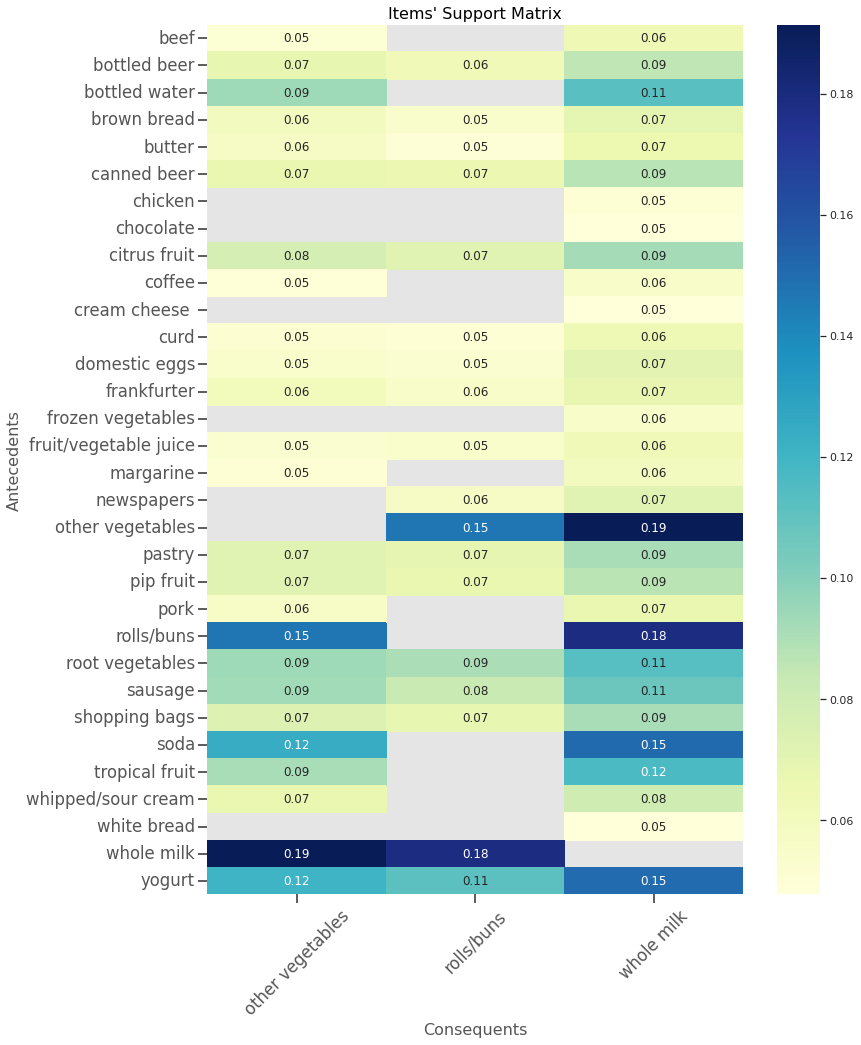

In [ ]:
pivot_support = rules_best_eda.pivot(index='antecedents', columns='consequents', values='support')

sns.set_context("talk")
plt.style.use('ggplot')
plt.subplots(figsize=(12, 16))
sns.set()
ax = sns.heatmap(data=pivot_support, annot=True, fmt='.2f', cmap='YlGnBu', cbar=True)
plt.title("Items' Support Matrix", fontsize=16, y=1.02)
ax.set_xlabel("Consequents",fontsize=16)
ax.set_ylabel("Antecedents",fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show() 

Baris kode di atas menggunakan method `pivot()` untuk mengubah dataframe `rules_best_eda` menjadi sebuah tabel pivot dengan `antecedents` sebagai indeks, `consequents` sebagai kolom, dan `support` sebagai nilai. Kemudian, method `heatmap()` dari library seaborn (sns) digunakan untuk membuat plot heatmap dari tabel pivot tersebut.

Plot heatmap ini akan menampilkan tabel pivot dengan setiap sel dari tabel tersebut diberi warna. Plot heatmap ini juga menampilkan nilai dukungan dari setiap aturan asosiasi yang terkait dalam bentuk angka di setiap sel tabel. Nilai dukungan tersebut ditampilkan dengan menggunakan parameter `annot=True` dan `fmt='.2f'`, yang akan menampilkan nilai dukungan dalam bentuk angka dengan 2 angka di belakang koma.

Selain itu, plot heatmap juga menggunakan parameter `cmap='YlGnBu'` untuk menentukan skala warna yang akan digunakan dalam plot. Skala warna YlGnBu adalah salah satu skala warna yang tersedia di library seaborn, yang menampilkan warna-warna dari hijau ke kuning ke biru sesuai dengan nilai dukungan yang lebih tinggi atau lebih rendah.

Plot heatmap ini juga menampilkan judul plot dengan parameter `title()` dan judul-judul dari sumbu-sumbu x dan y dengan parameter `set_xlabel()` dan `set_ylabel()`. Selain itu, parameter `xticks(rotation=45)` dan `yticks(rotation=0)` digunakan untuk memutar label-label dari sumbu-sumbu x dan y sesuai dengan sudut yang diinginkan.

Tujuan dari baris kode tersebut adalah untuk memvisualisasikan nilai dukungan dari aturan asosiasi yang terpilih dalam bentuk tabel pivot dan heatmap. Plot heatmap ini akan memudahkan kita dalam memahami dan membandingkan nilai dukungan dari aturan asosiasi yang berbeda, serta menemukan pola atau tren yang mungkin terdapat dalam data.

In [ ]:
pivot_confidence = rules_best_eda.pivot(index='antecedents', columns='consequents', values='confidence')

fig = ff.create_annotated_heatmap(pivot_confidence.to_numpy().round(2), 
                                  x=list(pivot_confidence.columns), 
                                  y=list(pivot_confidence.index), 
                                  colorscale=['grey', 'orange', 'red'], 
                                  font_colors=['white', 'white', 'white'])
fig.update_layout(
    template='simple_white',
    autosize=False,
    width=800,
    height=800,
    title="Lift Matrix",
    xaxis_title='Consequents',
    yaxis_title='Antecedents',
    legend_title="Legend Title",
    font=dict(
        family="Caliber",
        size=14,
        color="Black"
    )
)
fig.update_layout(title_x=0.22, title_y=0.98)
fig.update_traces(showscale=True)
fig.show()

Plot heatmap untuk mengetahui seberapa kuat asosiasi terkait nilai peningkatan

In [ ]:
network_A = list(rules_best_eda["antecedents"].unique())
network_B = list(rules_best_eda["consequents"].unique())
node_list = list(set(network_A+network_B))
G = nx.Graph()
for i in node_list:
    G.add_node(i)
for i,j in rules_best_eda.iterrows():
    G.add_edges_from([(j["antecedents"],j["consequents"])])
pos = nx.spring_layout(G, k=0.5, dim=2, iterations=400)
for n, p in pos.items():
    G.nodes[n]['pos'] = p

edge_trace = go.Scatter(
    x=[],
    y=[],
    line=dict(width=0.5,color='#888'),
    hoverinfo='none',
    mode='lines')
for edge in G.edges():
    x0, y0 = G.nodes[edge[0]]['pos']
    x1, y1 = G.nodes[edge[1]]['pos']
    edge_trace['x'] += tuple([x0, x1, None])
    edge_trace['y'] += tuple([y0, y1, None])

node_trace = go.Scatter(
    x=[],
    y=[],
    text=[],
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        colorscale='YlGnBu',
        reversescale=True,
        color=[],
        size=15,
        colorbar=dict(
            thickness=10,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line=dict(width=0)))
for node in G.nodes():
    x, y = G.nodes[node]['pos']
    node_trace['x'] += tuple([x])
    node_trace['y'] += tuple([y])

for node, adjacencies in enumerate(G.adjacency()):
    node_trace['marker']['color']+=tuple([len(adjacencies[1])])
    node_info = str(adjacencies[0]) +' has {} connections'.format(str(len(adjacencies[1])))
    node_trace['text']+=tuple([node_info])

fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='Connection of Top 10 Percentile Items',
                titlefont=dict(size=16),
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)))
fig.update_layout(title_x=0.5, title_y=0.96)
iplot(fig)

Plot jaringan untuk melihat hubungan antara 10 item persentil teratas

In [ ]:
rules_fix = rules.copy(deep=True)
rules_fix['antecedents'] = rules_fix['antecedents'].apply(lambda a: ', '.join(list(a)))
rules_fix['consequents'] = rules_fix['consequents'].apply(lambda a: ', '.join(list(a)))

fig=go.Figure()
fig.add_trace(
    go.Scatter(x=rules_fix['support'], y=rules_fix['zhang'], name='All Combinations', mode='markers', opacity=0.3)
)
fig.add_trace(
    go.Scatter(x=rules_best['support'], y=rules_best['zhang'], name='Top 5 Consequents', mode='markers')
)

annotaion_01={'x':'0.191380', 'y':'0.181562', 'showarrow':True, 'arrowhead':4, 'xshift':-2,'yshift':8,'text':'Other Vegetables', 'textangle':-90, 'font':{'size':12, 'color':'green'}}
annotaion_02={'x':'0.178553', 'y':'0.189591', 'showarrow':True, 'arrowhead':4, 'xshift':-2,'yshift':8,'text':'Rolls/buns', 'textangle':-90,'font':{'size':12, 'color':'green'}}
annotaion_03={'x':'0.151103', 'y':'0.091184', 'showarrow':True, 'arrowhead':4, 'xshift':-2,'yshift':8,'text':'Soda', 'textangle':-90,'font':{'size':12, 'color':'green'}}
annotaion_04={'x':'0.116470', 'y':'0.148768', 'showarrow':True, 'arrowhead':4, 'xshift':-2,'yshift':8,'text':'Tropical Fruit', 'textangle':-90,'font':{'size':12, 'color':'green'}}
annotaion_05={'x':'0.150590', 'y':'0.256640', 'showarrow':True, 'arrowhead':4, 'xshift':-2,'yshift':8,'text':'Yogurt', 'textangle':-90,'font':{'size':12, 'color':'green'}}

fig.update_layout({ 
    'annotations':[annotaion_01, annotaion_02, annotaion_03,
      annotaion_04, annotaion_05], 
      'showlegend':True, 'legend':{'x':0.76, 'y':0.04, 'bgcolor':'rgb(246, 228, 129)'}
      })
fig.update_xaxes(
        title_text = "Support",
        title_font = {"size": 16},
        title_standoff = 12)
fig.update_yaxes(
        title_text = "Confidence",
        title_font = {"size": 16},
        title_standoff = 12)
fig.update_layout(title='Contribution of The Top Items', title_x=0.5, title_y=0.86)
fig.show()

Scatter plot untuk melihat di mana hasil terbaik dari susu murni

In [ ]:
fig = px.scatter(rules_fix, x='support', y='confidence', 
                 color='lift', hover_data=['antecedents', 'confidence'],
                 labels={
                     "support": "Support",
                     "confidence": "Confidence",
                     'lift': 'Lift'
                 },
                title="Support v.s. Confidence")
fig.update_layout(title_x=0.5, title_y=0.86)
fig.show()

Perbandingan antara dukungan dan kepercayaan dari semua kombinasi

In [ ]:
network_A = list(rules_fix["antecedents"].unique())
network_B = list(rules_fix["consequents"].unique())
node_list = list(set(network_A+network_B))
G = nx.Graph()
for i in node_list:
    G.add_node(i)
for i,j in rules_fix.iterrows():
    G.add_edges_from([(j["antecedents"],j["consequents"])])
pos = nx.spring_layout(G, k=0.5, dim=2, iterations=400)
for n, p in pos.items():
    G.nodes[n]['pos'] = p

edge_trace = go.Scatter(
    x=[],
    y=[],
    line=dict(width=0.5,color='#888'),
    hoverinfo='none',
    mode='lines')
for edge in G.edges():
    x0, y0 = G.nodes[edge[0]]['pos']
    x1, y1 = G.nodes[edge[1]]['pos']
    edge_trace['x'] += tuple([x0, x1, None])
    edge_trace['y'] += tuple([y0, y1, None])

node_trace = go.Scatter(
    x=[],
    y=[],
    text=[],
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        colorscale='electric',
        reversescale=False,
        color=[],
        size=8,
        colorbar=dict(
            thickness=10,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line=dict(width=0)))
for node in G.nodes():
    x, y = G.nodes[node]['pos']
    node_trace['x'] += tuple([x])
    node_trace['y'] += tuple([y])

for node, adjacencies in enumerate(G.adjacency()):
    node_trace['marker']['color']+=tuple([len(adjacencies[1])])
    node_info = str(adjacencies[0]) +' has {} connections'.format(str(len(adjacencies[1])))
    node_trace['text']+=tuple([node_info])

fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='All Item Network',
                titlefont=dict(size=16),
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)))
fig.update_layout(title_x=0.5, title_y=0.96)
iplot(fig)

Plot jaringan untuk menunjukkan koneksi dari semua kombinasi

4.2 Dataset-2 (Transaction with Items Only)

In [ ]:
freq_bk = bk.apply(pd.value_counts).transpose().sum().sort_values(ascending=False)
freq_bk.head(10)

whole milk          2502.0
other vegetables    1898.0
rolls/buns          1716.0
soda                1514.0
yogurt              1334.0
root vegetables     1071.0
tropical fruit      1032.0
bottled water        933.0
sausage              924.0
citrus fruit         812.0
dtype: float64

Tinjau nomor semua item

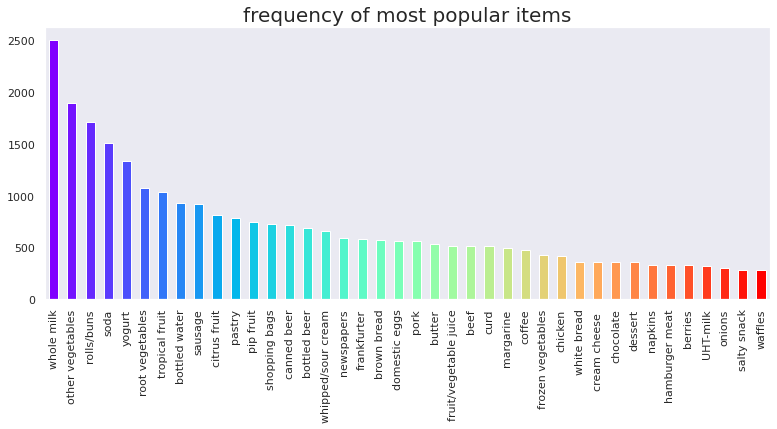

In [ ]:
color = plt.cm.rainbow(np.linspace(0, 1, 40))
freq_bk.head(40).plot.bar(color = color, figsize=(13,5))
plt.title('frequency of most popular items', fontsize = 20)
plt.xticks(rotation = 90 )
plt.grid()
plt.show()

Sekali lagi, plot diagram batang untuk meninjau 40 item teratas yang terjual

In [ ]:
bk.fillna('NA',inplace=True)
bk_2d = bk.values.tolist()
bk_2d[0]

['whole milk',
 'pastry',
 'salty snack',
 'NA',
 'NA',
 'NA',
 'NA',
 'NA',
 'NA',
 'NA',
 'NA']

Isi na sebagai 'NA' untuk mengubah setiap nilai menjadi string

In [ ]:
for i in range(len(bk_2d)):
    bk_2d[i] = [x for x in bk_2d[i] if not x=='NA']
bk_2d[0:5]

[['whole milk', 'pastry', 'salty snack'],
 ['sausage', 'whole milk', 'semi-finished bread', 'yogurt'],
 ['soda', 'pickled vegetables'],
 ['canned beer', 'misc. beverages'],
 ['sausage', 'hygiene articles']]

Ulangi setiap nilai yang bukan 'NA'

In [ ]:
TE = TransactionEncoder()
TE.fit(bk_2d)
item_matrix = TE.transform(bk_2d)
bk_item = pd.DataFrame(item_matrix, columns = TE.columns_)
print(bk_item.shape)
bk_item.head()

(14963, 167)


Instant food products  UHT-milk  abrasive cleaner  artif. sweetener  \
0                  False     False             False             False   
1                  False     False             False             False   
2                  False     False             False             False   
3                  False     False             False             False   
4                  False     False             False             False   

   baby cosmetics   bags  baking powder  bathroom cleaner   beef  berries  \
0           False  False          False             False  False    False   
1           False  False          False             False  False    False   
2           False  False          False             False  False    False   
3           False  False          False             False  False    False   
4           False  False          False             False  False    False   

   ...  turkey  vinegar  waffles  whipped/sour cream  whisky  white bread  \
0  ...   False    False    False               False   False        False   
1  ...   False    False    False               False   False        False   
2  ...   False    False    False               False   False        False   
3  ...   False    False    False               False   False        False   
4  ...   False    False    False               False   False        False   

   white wine  whole milk  yogurt  zwieback  
0       False        True   False     False  
1       False        True    True     False  
2       False       False   False     False  
3       False       False   False     False  
4       False       False   False     False  

[5 rows x 167 columns]

Membuat matriks

In [ ]:
bk_freq_items = apriori(bk_item, min_support=0.01, use_colnames=True, max_len=2)
bk_freq_items.sort_values(by = "support", ascending = False)

support                        itemsets
62  0.157923                    (whole milk)
40  0.122101              (other vegetables)
46  0.110005                    (rolls/buns)
52  0.097106                          (soda)
63  0.085879                        (yogurt)
..       ...                             ...
64  0.010559  (rolls/buns, other vegetables)
29  0.010559                         (herbs)
45  0.010493                (red/blush wine)
44  0.010158              (processed cheese)
53  0.010025                   (soft cheese)

[69 rows x 2 columns]

Dapatkan nilai dukungan oleh Apriori

In [ ]:
bk_rules = association_rules(bk_freq_items, metric = "confidence", min_threshold = 0)
bk_rules

antecedents         consequents  antecedent support  \
0        (rolls/buns)  (other vegetables)            0.110005   
1  (other vegetables)        (rolls/buns)            0.122101   
2  (other vegetables)        (whole milk)            0.122101   
3        (whole milk)  (other vegetables)            0.157923   
4        (rolls/buns)        (whole milk)            0.110005   
5        (whole milk)        (rolls/buns)            0.157923   
6              (soda)        (whole milk)            0.097106   
7        (whole milk)              (soda)            0.157923   
8            (yogurt)        (whole milk)            0.085879   
9        (whole milk)            (yogurt)            0.157923   

   consequent support   support  confidence      lift  leverage  conviction  
0            0.122101  0.010559    0.095990  0.786154 -0.002872    0.971117  
1            0.110005  0.010559    0.086481  0.786154 -0.002872    0.974249  
2            0.157923  0.014837    0.121511  0.769430 -0.004446    0.958551  
3            0.122101  0.014837    0.093948  0.769430 -0.004446    0.968928  
4            0.157923  0.013968    0.126974  0.804028 -0.003404    0.964550  
5            0.110005  0.013968    0.088447  0.804028 -0.003404    0.976350  
6            0.157923  0.011629    0.119752  0.758296 -0.003707    0.956636  
7            0.097106  0.011629    0.073635  0.758296 -0.003707    0.974663  
8            0.157923  0.011161    0.129961  0.822940 -0.002401    0.967861  
9            0.085879  0.011161    0.070673  0.822940 -0.002401    0.983638

Dapatkan dataframe dengan nilai support, confidence, dan lift berdasarkan Aturan Asosiasi

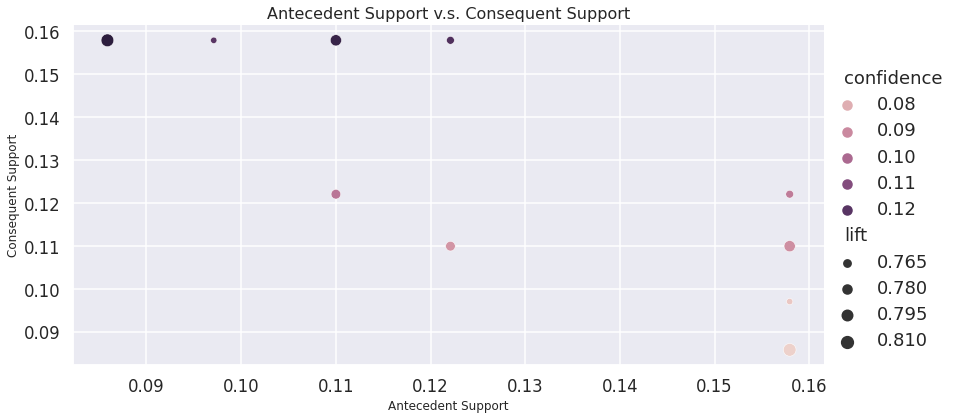

In [ ]:
sns.set_context("talk")
sns.relplot(x='antecedent support', y='consequent support', data=bk_rules, 
            size='lift', hue='confidence', height=6, aspect=2)
plt.title("Antecedent Support v.s. Consequent Support", fontsize=16, y=1.02)
plt.xlabel('Antecedent Support', fontsize=12)
plt.ylabel('Consequent Support', fontsize=12)
plt.show()

Hanya 10 kombinasi saat menyiapkannya berdasarkan setiap transaksi

In [ ]:
bk_rules_zhangs_list = zhangs_rule(bk_rules)
bk_rules = bk_rules.assign(zhang = bk_rules_zhangs_list)
bk_rules['antecedents'] = bk_rules['antecedents'].apply(lambda a: ', '.join(list(a)))
bk_rules['consequents'] = bk_rules['consequents'].apply(lambda a: ', '.join(list(a)))
bk_rules.head()

antecedents       consequents  antecedent support  consequent support  \
0        rolls/buns  other vegetables            0.110005            0.122101   
1  other vegetables        rolls/buns            0.122101            0.110005   
2  other vegetables        whole milk            0.122101            0.157923   
3        whole milk  other vegetables            0.157923            0.122101   
4        rolls/buns        whole milk            0.110005            0.157923   

    support  confidence      lift  leverage  conviction     zhang  
0  0.010559    0.095990  0.786154 -0.002872    0.971117 -0.234091  
1  0.010559    0.086481  0.786154 -0.002872    0.974249 -0.236553  
2  0.014837    0.121511  0.769430 -0.004446    0.958551 -0.254477  
3  0.014837    0.093948  0.769430 -0.004446    0.968928 -0.262461  
4  0.013968    0.126974  0.804028 -0.003404    0.964550 -0.214986

Tambahkan nilai Zhang untuk melengkapi dataframe

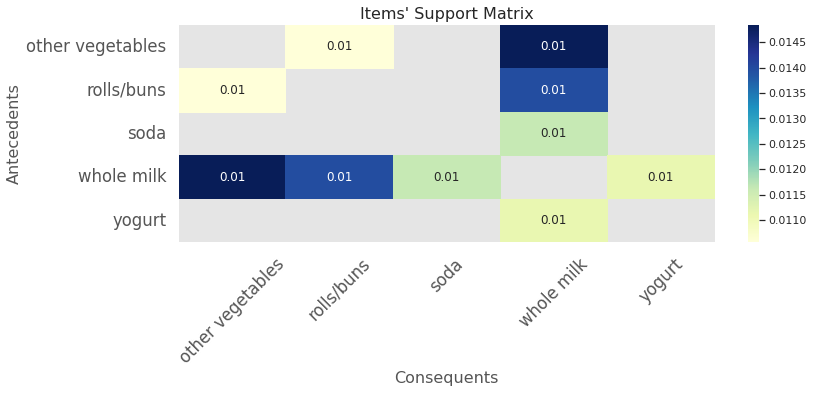

In [ ]:
bk_pivot_suport = bk_rules.pivot(index='antecedents', columns='consequents', values='support')

sns.set_context("talk")
plt.style.use('ggplot')
plt.subplots(figsize=(12, 4))
sns.set()
ax = sns.heatmap(data=bk_pivot_suport, annot=True, fmt='.2f', cmap='YlGnBu', cbar=True)
plt.title("Items' Support Matrix", fontsize=16, y=1.02)
ax.set_xlabel("Consequents",fontsize=16)
ax.set_ylabel("Antecedents",fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show() 

plot heatmap untuk mengetahui seberapa kuat asosiasi berdasarkan nilai lift

In [ ]:
bk_pivot_confi = bk_rules.pivot(index = 'antecedents', columns = 'consequents', values= 'confidence')

fig = go.Figure(data=go.Heatmap(x=bk_pivot_confi.columns, y=bk_pivot_confi.index, z=bk_pivot_confi, 
                                colorscale='ylgnbu', reversescale=False))
fig.update_layout(
    template='ggplot2',
    autosize=False,
    width=800,
    height=400,
    title="Confidence Matrix",
    xaxis_title='Consequents',
    yaxis_title='Antecedents',
    legend_title="Legend Title",
    font=dict(
        family="Courier New, monospace",
        size=14,
        color="Black"
    )
)
fig.update_layout(title_x=0.5, title_y=0.86)
fig.show()

tinjau heatmap untuk melihat apakah whole milk juga merupakan item dengan confidence tertinggi

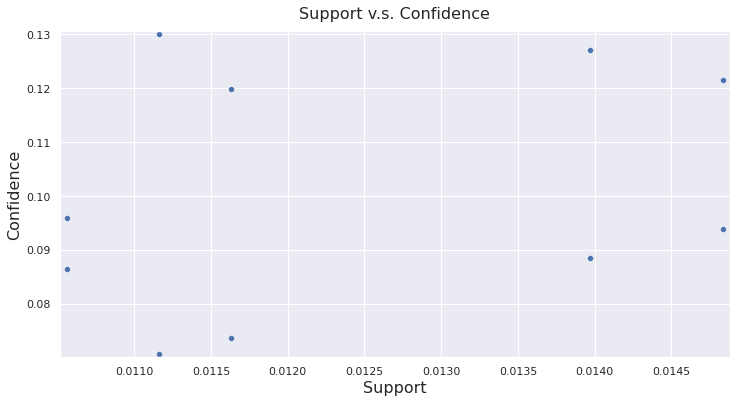

In [ ]:
plt.figure(figsize=(12,6))
ax = sns.scatterplot(x = "support", y = "confidence", data = bk_rules, alpha=1)
plt.title("Support v.s. Confidence", fontsize=16, y=1.02)
ax.set_xlabel("Support",fontsize=16)
ax.set_ylabel("Confidence",fontsize=16)
plt.margins(0.01,0.01)
plt.show()

Tujuan dari baris kode tersebut mungkin adalah untuk memvisualisasikan hubungan antara nilai support dan confidence dari aturan asosiasi yang terdapat dalam dataframe bk_rules. Plot scatter ini akan memudahkan kita dalam memahami dan membandingkan hubungan antara nilai support dan confidence dari aturan asosiasi yang berbeda, serta menemukan pola atau tren yang mungkin terdapat dalam data.

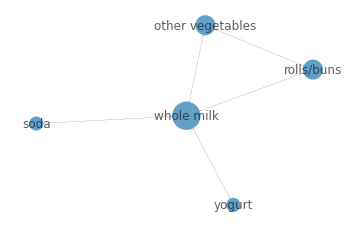

In [ ]:
bk_network = bk_rules[['antecedents', 'consequents']]

bk_network_G = nx.from_pandas_edgelist(
    bk_network,
    source = 'antecedents',
    target = 'consequents',
    create_using = nx.DiGraph())

network_bt = nx.in_degree_centrality(bk_network_G)
bk_network_bt = pd.DataFrame(list(network_bt.items()), columns = ['item', 'centrality'])
bk_network_bt = bk_network_bt.dropna(axis=0)

pos = nx.kamada_kawai_layout(bk_network_G)

sizes = [x[1]*100 for x in bk_network_G.degree()]

nx.draw_networkx(bk_network_G, pos, 
    with_labels = True, 
    node_size = sizes,
    width = 0.1, alpha = 0.7,
    arrowsize = 2, linewidths = 0)

plt.axis('off')
plt.show()

Baris kode di atas digunakan untuk memvisualisasikan data asosiasi yang terdapat dalam dataframe bk_rules sebagai sebuah grafik jaringan (network graph).

Pertama, dataframe bk_rules dipisahkan menjadi dataframe bk_network yang hanya berisi kolom antecedents dan consequents. Kemudian, method from_pandas_edgelist() dari library NetworkX (nx) digunakan untuk membuat objek grafik jaringan dari dataframe bk_network.

Method in_degree_centrality() juga digunakan untuk menghitung tingkat centralitas (centrality) dari setiap node dalam grafik jaringan. Centralitas merupakan ukuran yang menunjukkan seberapa penting suatu node dalam suatu grafik jaringan.

Method kamada_kawai_layout() digunakan untuk menentukan posisi dari setiap node dalam grafik jaringan.

Selanjutnya, method draw_networkx() digunakan untuk menggambar grafik jaringan tersebut. Beberapa parameter yang dapat ditentukan melalui method ini antara lain pos, with_labels, node_size, width, alpha, arrowsize, dan linewidths.
Tujuan dari baris kode tersebut adalah untuk memvisualisasikan data asosiasi sebagai sebuah grafik jaringan, sehingga kita dapat dengan mudah memahami hubungan antar item yang terdapat dalam data. Grafik jaringan ini akan membantu kita dalam memahami pola atau tren yang terdapat dalam data, serta mengambil keputusan bisnis yang tepat sesuai dengan hasil analisis.

# 4. Kesimpulan

Secara keseluruhan, ada beberapa pandangan sebagai berikut:

   1.  Sepuluh item terlaris adalah susu segar, sayuran lain, roti, soda, yogurt, sayuran akarnya, buah tropis, air mineral, sosis, dan buah sitrus.

   2. Lima item yang paling sering dibeli bersama susu segar adalah sayuran lain, roti, soda, buah tropis, dan yogurt.

   3. Setiap item di percentile teratas dari semua kombinasi memiliki tingkat kepercayaan yang tinggi bahwa pelanggan membeli item tersebut bersama susu segar.

   4. Menurut grafik jaringan, susu segar memiliki jumlah koneksi terbanyak dengan item lain.

   5. Total item dalam dua dataset ini sama. Namun, jika menghasilkan dataframe analisis keranjang berdasarkan setiap transaksi, jumlah kombinasi akan lebih sedikit dibandingkan dengan membuatnya berdasarkan ID pelanggan.

Saran analisis selanjutnya:

   1. Karena terdapat dataset dengan tanggal transaksi dan ID pelanggan, dataset tersebut juga dapat dilanjutkan dengan analisis tren penjualan atau perilaku pelanggan.

   2. Pilih item lain untuk mengeksplorasi apa saja yang harus disiapkan sebagai item yang sering dibeli bersama agar tidak terjadi kekurangan produk.

   3. Jenis visual lain untuk mengeksplorasi lebih banyak wawasan.